In [1]:
import astropy
from astropy.wcs import WCS
from astropy import wcs
from astropy.io import fits
from astropy.coordinates import Angle, SkyCoord
from astropy.utils.data import get_pkg_data_filename
from astropy.nddata import Cutout2D
import numpy as np
from matplotlib.patches import Ellipse, Rectangle
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator

import warnings
warnings.filterwarnings("ignore")

In [20]:
# ## Load the data
# #hdul = fits.open('V167HER_cln.fits')
# image, aips = fits.open('V167HER_cln.fits') 
# #view header data.header

# array = image.data
# #can use fits.getdata(path)
# image_data = array[0][0] #get's just the image values
# image_wcs = WCS(image.header)

# #hi = image_wcs.wcs.print_contents()
# rms = image.header['NOISE']
# max = image.header['DATAMAX']
# min = image.header['DATAMIN']


# type(image)
#image.header

In [9]:
def center(hdu):
    centpxl_ra, centpxl_dec = hdu.header['CRPIX1'], hdu.header['CRPIX2']
    center_ra, center_dec = hdu.header['CRVAL1'], hdu.header['CRVAL2']
    scale_ra, scale_dec = hdu.header['CDELT1'], hdu.header['CDELT2']
    npxl_ra, npxl_dec = hdu.header['NAXIS1'], hdu.header['NAXIS2']
    
    
    return centpxl_ra, centpxl_dec, center_ra, center_dec, scale_ra, scale_dec, npxl_ra, npxl_dec


def beam(hdu):
    b_major, b_minor, b_pa = hdu.header['BMAJ'], hdu.header['BMIN'], hdu.header['BPA']#*un.degree
    
    return b_major, b_minor, b_pa


def info(hdu):
    obs_code, obs_date = hdu.header['OBSERVER'], hdu.header['DATE-OBS']
    obsra, obsdec = hdu.header['OBSRA'], hdu.header['OBSDEC']
    rms, max, min = hdu.header['NOISE'], hdu.header['DATAMIN'], hdu.header['DATAMAX']
    
    return obs_code, obsra, obsdec, rms, max, min

def load(filename):
    #file = get_pkg_data_filename(filename)
    image = fits.open(filename)[0]
    array = image.data
    image_data = array[0][0]
    wcs= WCS(image.header)
    
    return(image_data, wcs, image)

def cut(data, wcs, hdu, center, box):
    size = un.Quantity(box, un.pix)
    cutout = Cutout2D(data, position=center, size=size, wcs=wcs)
    hdu.header.update(cutout.wcs.to_header())
    hdu.data = cutout.data
    wcs_cut = WCS(hdu.header)
    # wcs_cut_tmp2 = wcs_cut_tmp1.dropaxis(
    
    return(hdu.data,wcs_cut,hdu)

In [21]:
#img_data, wcsb, image = load('V1674HERD_cln.fits')
img_data, wcsb, image = load('V1674HERD_CLN.fits')
tmp = wcsb.dropaxis(3)
mywcsb = (tmp.dropaxis(2))


In [23]:

obs, obsra, obsdec, rms, maxb, minb = info(image)
b_major, b_minor, b_pa = beam(image)

centpxl_ra, centpxl_dec, center_ra, center_dec, scale_ra, scale_dec, npxl_ra, npxl_dec = center(image)
size_box = un.Quantity((130,130), un.pix)
mydata = np.ma.masked_invalid(img_data)

minb

9.5325049187522e-05

In [24]:
center_ra, center_dec

(284.379075, 16.894302777778)

In [30]:
#beam stuff

b_conv = (3600)*(1e3)
pixscale = image.header['CDELT2']
beamsiz = b_major*b_conv

sbar_scale = 10/beamsiz

In [25]:
print(scale_ra, scale_dec)
print(npxl_ra,npxl_dec)
print(obsra)
print(minb, maxb)
print(center_ra,center_dec)
mywcsb.world_to_pixel(SkyCoord(ra=284.37907083333*un.degree, dec=16.894302222222*un.degree))

-4.1666668951787e-08 4.1666668951787e-08
1024 1024
284.379079167
9.5325049187522e-05 -5.0190057663713e-05
284.379075 16.894302777778


(array(468.10993136), array(642.24311591))

In [26]:
cut_data, cut_wcs, cut_hdu = cut(img_data, mywcsb, image, center=(556,499), box=(300,300))
#284.37907401), array(16.89430135

Text(284.37906916666634, 16.894296736111002, '10 mas')

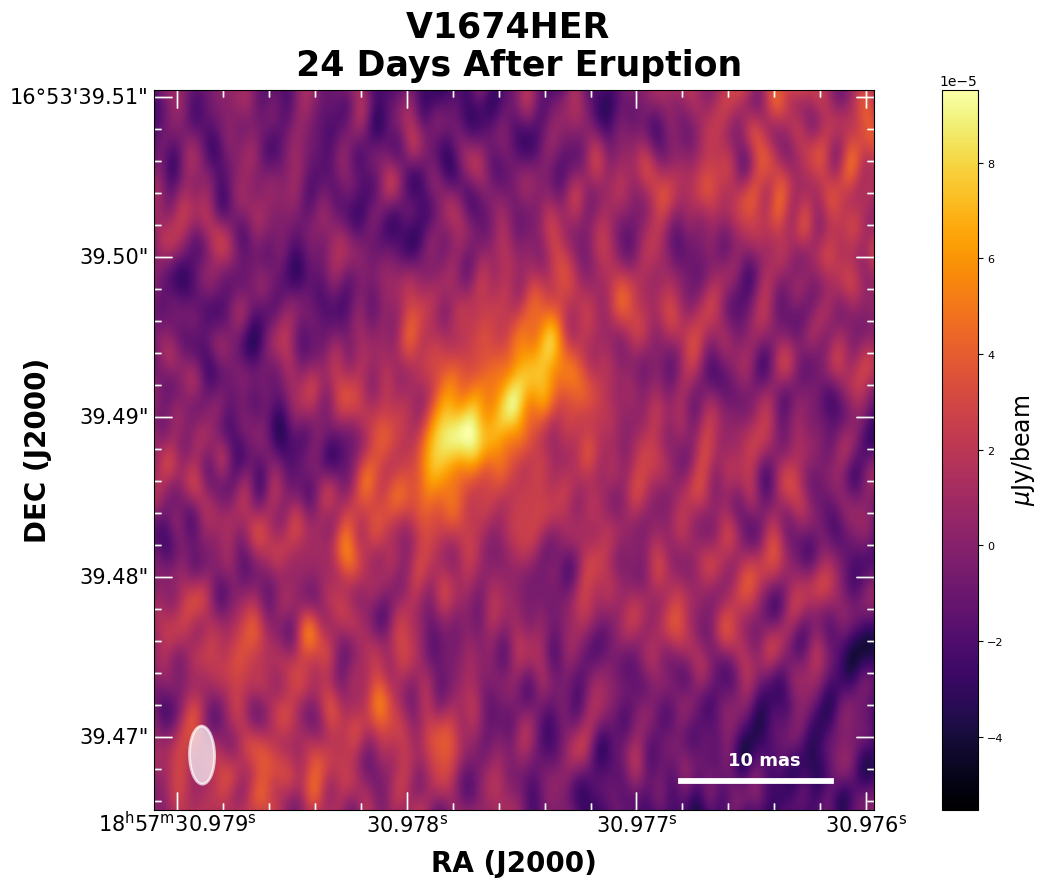

In [50]:
fig = plt.figure(figsize=(17,9))
#ax =  plt.subplot(projection=wcsb, slices=('x','y',0,0))


#cut_data = img_data[384:640,384:640]
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=cut_wcs, slices=('x','y',1,1))#, slices=('x', 'y',0, 0) #wcsb[3,4]


ra = ax.coords[0]
dec = ax.coords[1]

#r
#ra.set_major_formatter('hh:mm:ss');
ra.set_axislabel('RA (J2000)', minpad=1, fontsize=20, weight='heavy');

dec.set_axislabel('DEC (J2000)', minpad=-1.0, fontsize=20, weight='heavy');
#

ax.set_title(f'V1674HER \n 24 Days After Eruption',fontsize=25, pad=10, weight='heavy')

dec.display_minor_ticks(True)
ra.display_minor_ticks(True)
ax.tick_params(which='both',direction='in',color='white',length=13,width=1,labelsize=15)
ax.tick_params(which='minor', length=5)
# , slices=('x','y',0,0


im = ax.imshow(cut_data, cmap='inferno', vmin= minb, vmax=maxb,transform=ax.get_transform(cut_wcs[0,0]), origin='lower')
cbar = fig.colorbar(im, location='right')
#fmt = matplotlib.ticker.FuncFormatter(func)

cbar.ax.set_ylabel(r'$\mu$Jy/beam', fontsize=17)
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(8)

    
    
beam_ra  = center_ra - 65 *scale_ra + b_major
beam_dec = center_dec - 165 *scale_dec + b_major

sbar_ra = center_ra + 185 *scale_ra 
sbar_dec = center_dec - 152*scale_dec

sbartxt_ra = center_ra + 140 *scale_ra 
sbartxt_dec = center_dec - 145*scale_dec
sbar_text = '10 mas'


beam3 = Ellipse((beam_ra, beam_dec), height=b_major, width=b_minor, angle=b_pa,transform=ax.get_transform('fk5'),edgecolor='w', facecolor = 'w', alpha=0.7, lw=2)

scale = Rectangle((sbar_ra, sbar_dec), width = (b_major *sbar_scale), height=(b_minor/10), transform= ax.get_transform('fk5'), 
                  color= 'w',edgecolor='w', facecolor = 'w', lw=2);
# beam3 = Ellipse((
ax.add_patch(beam3)
ax.add_patch(scale)
ax.text(sbartxt_ra, sbartxt_dec, sbar_text, transform=ax.get_transform('fk5'), color='w', weight='bold', fontsize=13)
#cut_hdu.writeto('./latest/07062021.fits')

In [8]:
imgd_data, d_wcs, imaged = load('V1674HERD_3.fits')
rmsd = imaged.header['NOISE']
maxd = imaged.header['DATAMAX']
mind = imaged.header['DATAMIN']

In [9]:
# def fix_aplpy_fits(aplpy_obj, dropaxis=2):
#     #"""This removes the degenerated dimensions in APLpy 2.X...
#     #The input must be the object returned by aplpy.FITSFigure().
#     #`dropaxis` is the index where to start dropping the axis (by default it assumes the 3rd,4th place).
#     #"""
#     temp_wcs = aplpy_obj._wcs.dropaxis(dropaxis)
#     temp_wcs = temp_wcs.dropaxis(dropaxis)
#     aplpy_obj._wcs = temp_wcs
    
# fig = aplpy.FITSFigure(image)
# fix_aplpy_fits(fig)

# #rms = image_data.std()
# fig.show_colorscale(vmin=min, vmax=max)
# figd = aplpy.FITSFigure('V1674HERD_3.fits')
# fix_aplpy_fits(figd)
# figd.show_colorscale(vmin=mind,vmax=maxd)

In [9]:
imgd_data, wcsd, imaged = load('V1674HERB.fits')
tmp = wcsd.dropaxis(3)
mywcsd = (tmp.dropaxis(2))

 
obsd, obsrad, obsdecd, rmsd, maxd, min = info(imaged)
b_majord, b_minord, b_pad = beam(imaged)

centpxl_rad, centpxl_decd, center_rad, center_decd, scale_rad, scale_decd, npxl_rad, npxl_decd = center(imaged)
# size_box = un.Quantity((130,130), un.pix)
# mydata = np.ma.masked_invalid(img_data)
cut_datad, cut_wcsd, cut_hdud = cut(imgd_data, mywcsd, imaged, center=(512,512), box=(256,256))


In [11]:
center_rad

284.37907083333

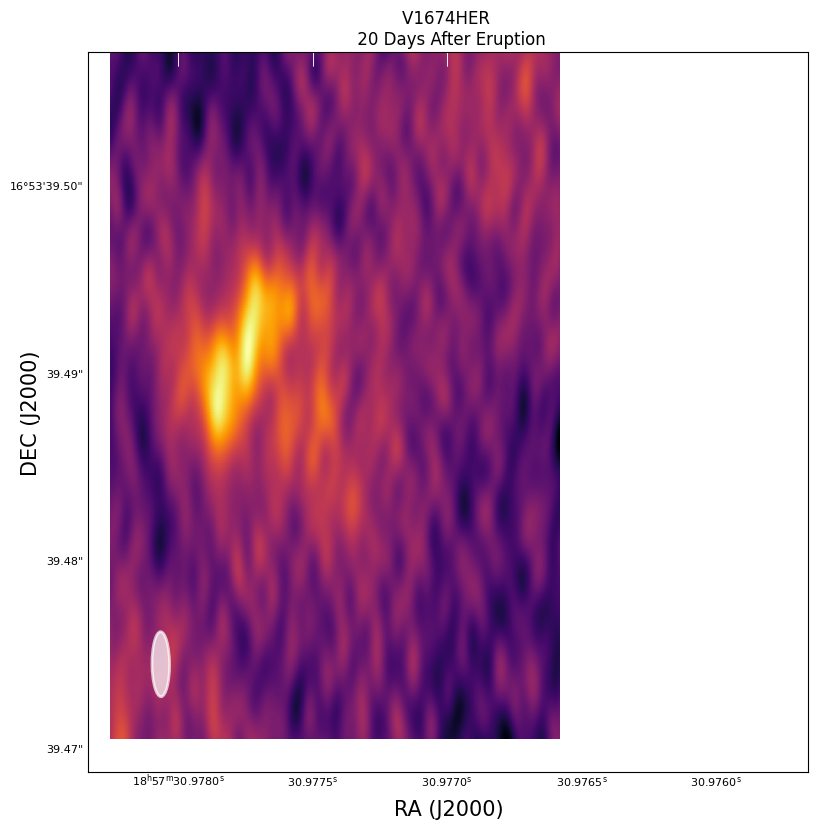

In [16]:
figd = plt.figure(figsize=(11,9))
#ax =  plt.subplot(projection=wcsb, slices=('x','y',0,0))


#cut_data = img_data[384:640,384:640]
axd = figd.add_axes([0.1, 0.1, 0.8, 0.8], projection=cut_wcsd, slices=('x','y',1,1))#, slices=('x', 'y',0, 0) #wcsb[3,4]


rad = axd.coords[0]
decd = axd.coords[1]

#r
#ra.set_major_formatter('hh:mm:ss');
rad.set_axislabel('RA (J2000)', minpad=1, fontsize=15);

decd.set_axislabel('DEC (J2000)', minpad=-1.0, fontsize=15)
#

axd.set_title(f'V1674HER \n 20 Days After Eruption')

decd.display_minor_ticks(True)
axd.tick_params(which='both',direction='in',color='white',length=10,width=0.5,labelsize=8)
axd.tick_params(which='minor', length=5)
# , slices=('x','y',0,0


imd = axd.imshow(cut_datad, cmap='inferno', transform=ax.get_transform(cut_wcsd[0,0]), origin='lower')
cbard = figd.colorbar(im, location='right')
#fmt = matplotlib.ticker.FuncFormatter(func)

cbard.ax.set_ylabel(r'$\mu$Jy/beam', fontsize=15)
for t in cbard.ax.get_yticklabels():
    t.set_fontsize(8)
# # beam = ax.add_beam(im)
# beam_ra  = obsra #- 100 *scale_ra*npxl_ra + b_major
# beam_dec = obsdec #- 100 *scale_dec*npxl_dec + b_major# edgecolor='r', facecolor='none', hatch=r"//",lw=2
# #2
beam_rad  = center_rad - 80 *scale_rad + b_majord
beam_decd = center_decd - 125 *scale_decd + b_majord
#beam2 = Ellipse((beam_ra, beam_dec), height=b_major, width=b_minor, angle=b_pa, transform=ax.get_transform('fk5'), color='white')
#0x150bc75d0


beam3d = Ellipse((beam_rad, beam_decd), height=b_majord, width=b_minord, angle=b_pad ,transform=ax.get_transform('fk5'),edgecolor='w', facecolor = 'w', alpha=0.7, lw=2)
# beam3 = Ellipse((
axd.add_patch(beam3d)
